# Analysis of Paris Accident Data - Part 3: Strategic Insights and Recommendations

This notebook analyzes road accident data for Paris and implements a data-driven strategy to help city councils deploy concrete solutions to reduce road accidents in their districts. 

Data analysis in this notebook includes spatial (heatmap with Paris basemap), temporal, meteorological (with severity analysis) and accident type analyses.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting
%matplotlib inline

# Set a style for plots
sns.set(style='whitegrid')

In [2]:
# Load the enriched dataset
df = pd.read_csv('../data/accidents_parsed.csv', sep=';')

## Analysis: Top 3 Arrondissements with Most Accidents

We identify the top 3 arrondissements (districts) that have recorded the highest number of accidents.

In [3]:
# Count accidents per arrondissement
arrondissement_counts = df['arrondissement'].value_counts()
print(arrondissement_counts.head(10))

# Extract the top 3 arrondissements
top_arrondissements = arrondissement_counts.head(3).index.tolist()
print('Top 3 arrondissements:', top_arrondissements)

arrondissement
16    4280
12    3500
17    3079
19    2999
15    2851
13    2779
20    2572
18    2561
8     2418
14    2403
Name: count, dtype: int64
Top 3 arrondissements: [16, 12, 17]


## Spatial Analysis: Accident Density Heatmap for Top 3 Arrondissements


Below we plot a heatmap of accident density for the top 3 arrondissements. A basemap of Paris is overlaid using geopandas and contextily so that dangerous zones can be accurately located.

/var/folders/wf/1kqrl69s07v9gqlbvq7zyxpc0000gn/T/ipykernel_15490/641102287.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


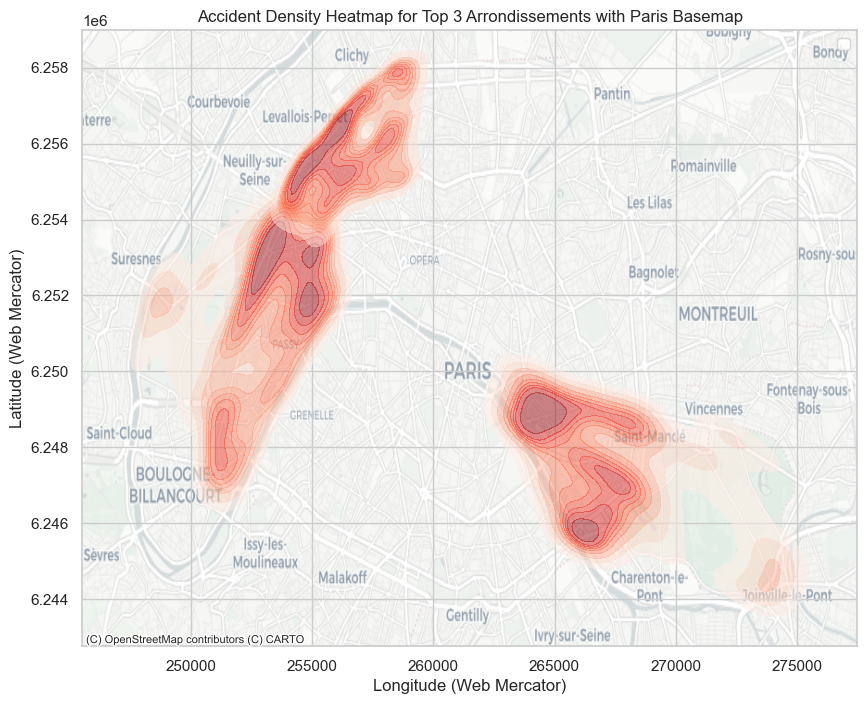

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Filter data for top 3 arrondissements
df_top = df[df['arrondissement'].isin(top_arrondissements)]

# Create a GeoDataFrame using longitude and latitude
geometry = [Point(xy) for xy in zip(df_top['longitude'], df_top['latitude'])]
gdf_top = gpd.GeoDataFrame(df_top, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for plotting with a basemap
gdf_top = gdf_top.to_crs(epsg=3857)

# Plot a KDE density plot for each top arrondissement over the Paris basemap
fig, ax = plt.subplots(figsize=(10, 8))
for arr in top_arrondissements:
    subset = gdf_top[gdf_top['arrondissement'] == arr]
    sns.kdeplot(x=subset.geometry.x, y=subset.geometry.y, fill=True, cmap='Reds', alpha=0.5, label=f'Arrondissement {arr}', ax=ax)

# Add a basemap using CartoDB Positron
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Accident Density Heatmap for Top 3 Arrondissements with Paris Basemap')
ax.set_xlabel('Longitude (Web Mercator)')
ax.set_ylabel('Latitude (Web Mercator)')
plt.legend()
plt.show()

The heatmap hints that the concentration of accidents in central Paris may be tied not only to higher traffic density but also to complex urban design features—such as 3 areas (La Défense, Peripherique, A4 highway) closely spaced intersections and mixed-use spaces—that create dynamic environments where vehicle, pedestrian, and cyclist paths frequently conflict. 

## Top 3 Accident-Prone Streets per Arrondissement

For each of the top 3 arrondissements, we determine the top 3 streets with the highest number of accidents. This helps focus interventions on these critical areas.

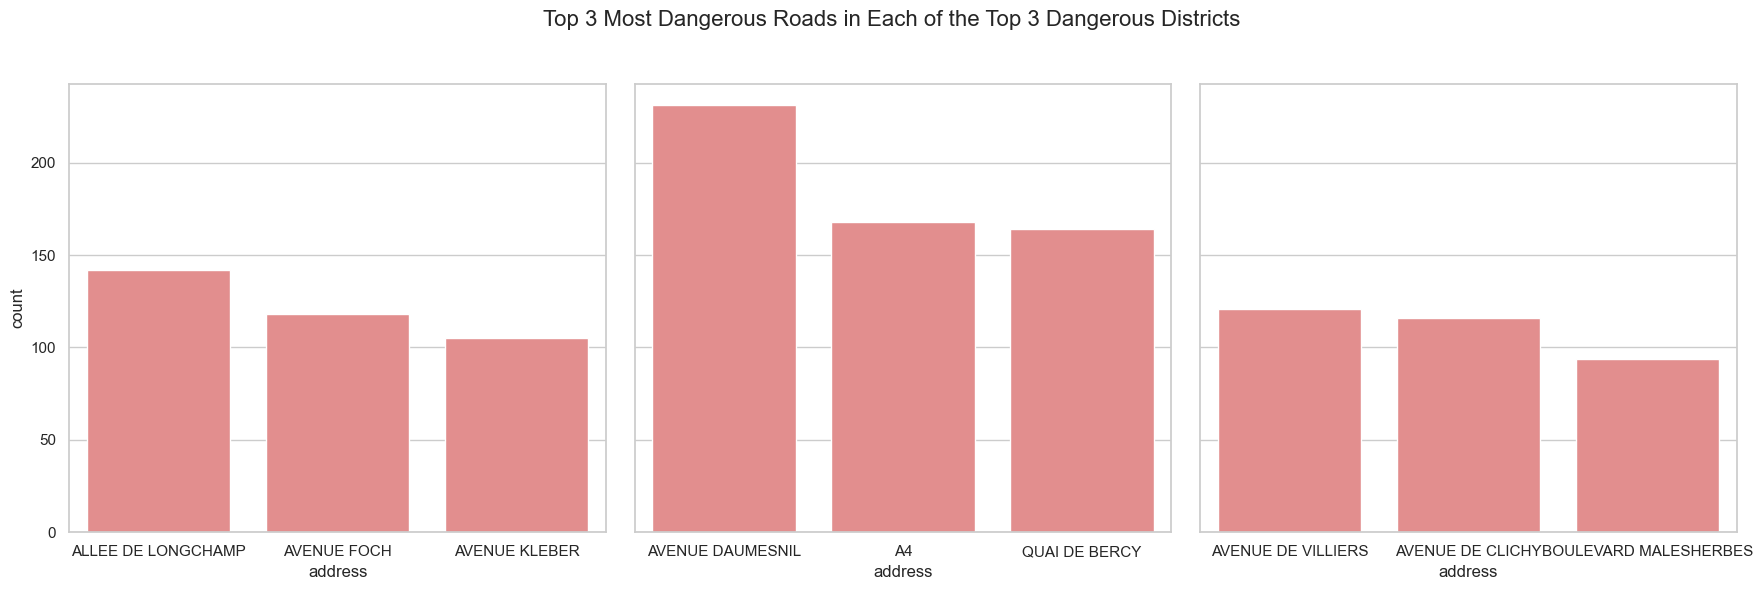

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by district and street, counting the number of accidents per street
top_streets = df.groupby(['arrondissement', 'address']).size().reset_index(name='count')

# Top 3 most dangerous districts (assumed to be previously identified)
# For example, if they are stored in a variable called top_arrondissements:
top_arrondissements = [16, 12, 17]  # Modify if needed

# Create a subplot with one chart per district
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each top district and plot the top 3 dangerous streets
for i, district in enumerate(top_arrondissements):
    # Filter for the current district and sort by accident count
    district_df = top_streets[top_streets['arrondissement'] == district].sort_values(by='count', ascending=False).head(3)
    
    # Create a barplot for the district
    sns.barplot(
    x='address',
    y='count',
    data=district_df,
    color='lightcoral',  # Single color
    ax=axs[i]
)


plt.suptitle("Top 3 Most Dangerous Roads in Each of the Top 3 Dangerous Districts", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The presence of major thoroughfares in all three districts—such as highways and large boulevards—underscores the need for targeted traffic calming measures, improved signage, and better pedestrian infrastructure to reduce overall collision rates. Furthermore, the inclusion of the highway "A4" points to the necessity of considering fundamentally different road types and their associated risks, implying that a one-size-fits-all safety strategy across all "dangerous" streets will be ineffective.

## Temporal Analysis

We analyze the accident frequency over time to identify specific periods (e.g., certain months) with higher accident occurrences. This information is crucial for planning targeted awareness campaigns and reinforcing road safety during high-risk periods.

/var/folders/wf/1kqrl69s07v9gqlbvq7zyxpc0000gn/T/ipykernel_15490/3811433090.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='month', palette='viridis')


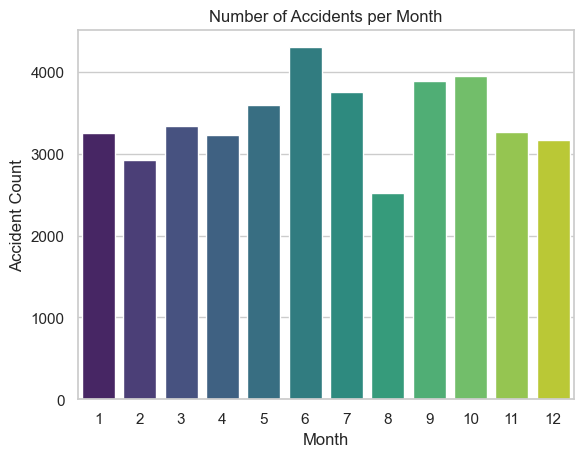

In [6]:
# Convert accident_date to datetime and extract the month
df['accident_date'] = pd.to_datetime(df['accident_date'])
df['month'] = df['accident_date'].dt.month

# Plot the number of accidents per month with hue assigned to 'month'
ax = sns.countplot(data=df, x='month', palette='viridis')

if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.title('Number of Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.show()


## Meteorological Severity Analysis

While most accidents occur under "normal" weather conditions, we now assess the **severity** of accidents by weather type. A severity metric is created using the following assumptions:

- Minor injuries are weighted as 1
- Hospitalizations are weighted as 2
- Fatalities are weighted as 3

This analysis will help identify if adverse weather (even with fewer accidents) leads to more severe outcomes.

In [7]:
def convert_bool(x):
    return 1 if str(x).strip().upper() == 'TRUE' else 0

df['minor_injury'] = df['victim_minor_injuries?'].apply(convert_bool)
df['hospitalized'] = df['victim_hospitalized?'].apply(convert_bool)
df['deceased'] = df['victim_deceased?'].apply(convert_bool)

# Create severity column
df['severity'] = df['minor_injury'] + 2 * df['hospitalized'] + 3 * df['deceased']


# Severity Analysis by Weather and Road Surface Conditions


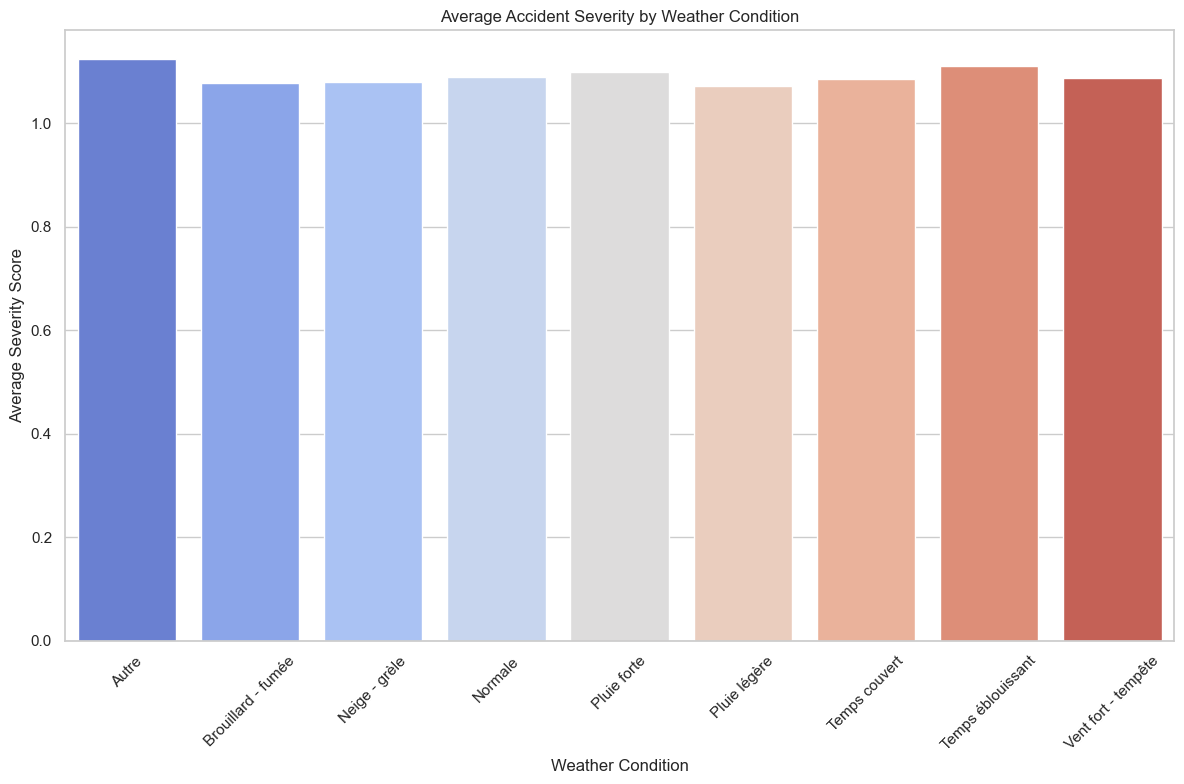

In [8]:
severity_by_weather = df.groupby("weather_condition")["severity"].mean().reset_index()


plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='weather_condition', 
    y='severity', 
    data=severity_by_weather, 
    hue='weather_condition', 
    palette='coolwarm', 
    dodge=False
)
plt.xticks(rotation=45)
plt.title('Average Accident Severity by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Severity Score')

# Check if a legend exists and remove it
legend = ax.get_legend()
if legend is not None:
    legend.remove()

plt.tight_layout()
plt.show()


This analysis does not yiled interesting results because "Others" is the main category regarding severity, let's dive into a further analysis by looking at road conditions too.

## Compute the average severity grouped by weather condition and road surface

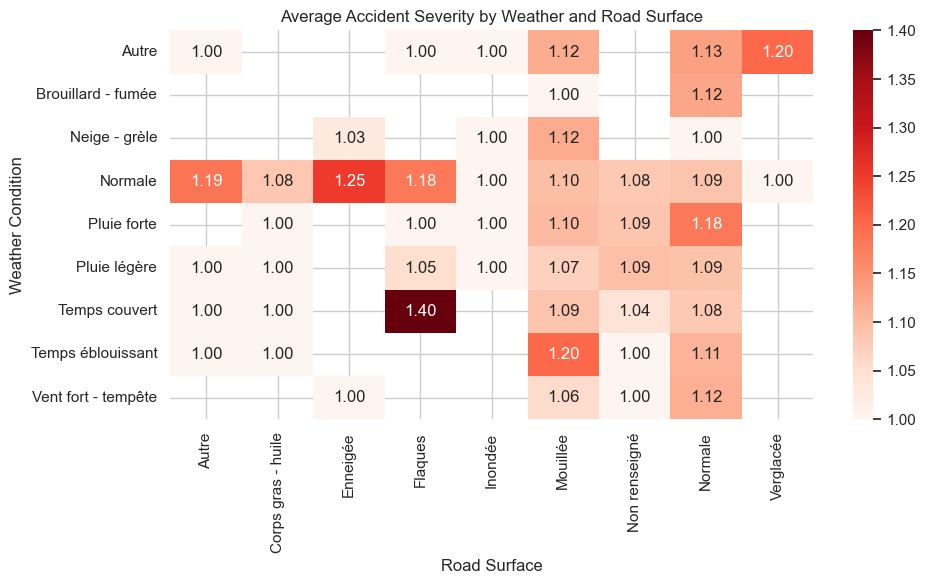

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by both weather_condition and road_surface
severity_by_road_weather = (
    df.groupby(["weather_condition", "road_surface"])["severity"]
    .mean()
    .reset_index()
)

# Sort so the heatmap looks consistent
severity_by_road_weather = severity_by_road_weather.sort_values(
    by=["weather_condition", "road_surface"]
)

# Pivot table for visualization (rows: weather, columns: road surface)
pivot_table = severity_by_road_weather.pivot(
    index="weather_condition",
    columns="road_surface",
    values="severity"
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="Reds", fmt=".2f")
plt.title("Average Accident Severity by Weather and Road Surface")
plt.xlabel("Road Surface")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()


The heatmap reveals that seemingly benign conditions like "Temps couvert" (Overcast) can be surprisingly dangerous when combined with specific road hazards like puddles, suggesting that driver perception of risk might be lower in these scenarios. Furthermore, the consistently elevated severity across various weather types when the road is "Mouillée" -> "Wet" highlights the disproportionate impact of road surface contamination, regardless of broader weather patterns.

# Conclusion

Our analysis of Paris accident data reveals several strategic insights:

1. **Spatial Distribution**:
   - Arrondissements 16, 12, and 17 have the highest accident counts.
   - Heatmap analysis shows distinct clusters within these districts, indicating specific zones that need immediate attention.
   - The top 3 accident-prone streets in each district account for a significant percentage of total accidents, suggesting a focus on these areas for targeted safety measures.

2. **Temporal Trends**:
   - The monthly accident frequency indicates that certain periods (June, September, October) have higher occurrences.
   - This insight can be used to launch targeted prevention campaigns and increase road safety measures during high-risk periods.

3. **Meteorological Impact**:
   - Although most accidents occur in normal weather conditions, adverse weather (e.g., rain, fog) is associated with higher average severity.
   - Enhanced road maintenance, improved lighting, and tailored public awareness campaigns during adverse weather conditions are recommended.


**Next Steps for Further Analysis**:
   - Perform a detailed clustering analysis to refine the identification of dangerous streets.
   - Explore spatial–temporal modeling to predict high-risk zones and periods.
   - Investigate correlations between urban infrastructure characteristics and accident severity.
"""